In [1]:
import os
# Utility imports
from rfa_utils import general_fns as gf
from rfa_utils import clean_crypto as cc

In [2]:
crypto_path = os.path.join('data/crypto/', 'imputed-data.xlsx')
# Import crypto dataframes except XMR
crypto = gf.import_excel(
    crypto_path,
    ['btc', 'xrp', 'doge', 'ltc', 'bch', 'xlm', 'bsv', 'zec', 'dash']
)
# Convert to pandas
for df in crypto:
    crypto[df] = crypto[df].to_pandas()
    crypto[df].index = crypto[df]['date']
    crypto[df] = crypto[df].drop(columns=['date'])

In [3]:
def crypto_fee_percentage(dfs: dict) -> dict:
    """Calculate and create a new column for fee percentage based on average transaction fees and values"""
    for _, df in dfs.items():
        df['fee_percentage'] = (df['average_transaction_fees'] / df['average_transaction_value']) * 100
    return dfs

In [4]:
# Add fee percentage column to crypto dict
crypto = crypto_fee_percentage(crypto)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid") 

def crypto_fee_percentage_lineplot(dfs: dict) -> None:
    """Plot the fee percentage column for all dataframes in the dictionary on a weekly basis"""
    plt.figure(figsize=(10, 6))
    for name, df in dfs.items():
        # Resample to weekly frequency 
        df_weekly = df.resample('W').median()  
        # Calculate rolling mean with 4 week window
        df_roll = df_weekly.rolling(4, min_periods=1).mean()
        # Plot smoothed line
        sns.lineplot(data=df_roll, x=df_roll.index, y='fee_percentage', label=name)
    plt.xlabel('date')
    plt.ylabel('Fee Percentage')
    plt.title('Fee Percentage Plot (Weekly)')
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

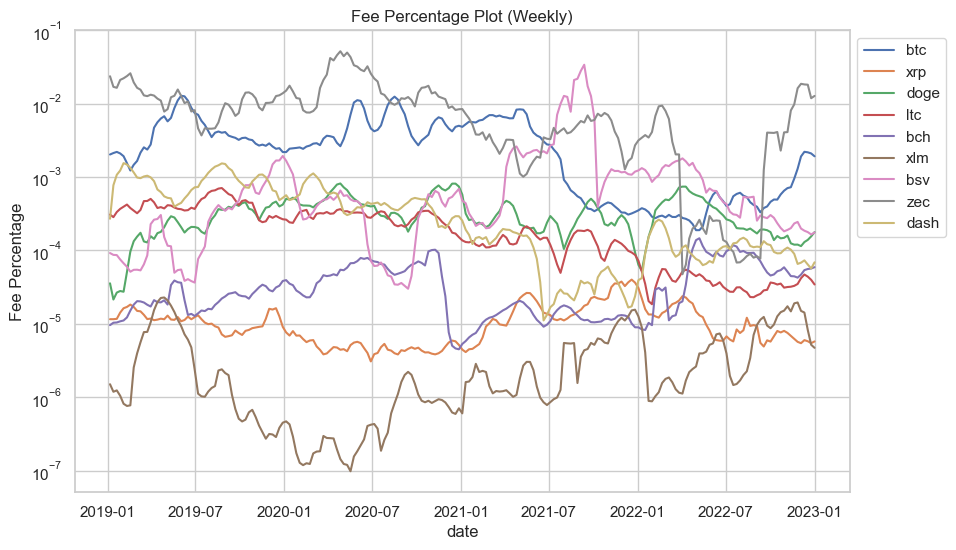

In [6]:
# Create lineplots for fee percentages
crypto_fee_percentage_lineplot(crypto)

In [7]:
import pandas as pd

def crypto_fees_scenarios(dfs: dict) -> pd.DataFrame:
    """Create a dataframe that has different scenarios for each year for crypto fee percentage"""
    scenario_data = []
    for name, df in dfs.items():
        for year in range(2019, 2023):
            df_year = df[df.index.year == year]
            # Get the mean value of fee_percentage directly
            fee_percent = df_year['fee_percentage'].describe().loc['mean']
            # Get the mean value of 24h_volume directly
            volume_weight = df_year['24h_volume'].mean()
            scenario_data.append({
                'crypto': name,
                'year': year,
                'mean_fee_percent': fee_percent,
                'volume_weight': volume_weight
            })
    # Create dataframe and reorder columns
    scenario_df = pd.DataFrame(scenario_data)
    scenario_df = scenario_df.reindex(columns=['crypto', 'year', 'mean_fee_percent', 'volume_weight'])
    return scenario_df

def combine_average_case(scenario_df: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe that has the weighted_average_case for each year using the volume_weight"""
    combined_data = []
    for year in range(2019, 2023):
        scenario_df_year = scenario_df[scenario_df['year'] == year]
        # Calculate the weighted_average_case using the formula
        weighted_mean_fee = (scenario_df_year['mean_fee_percent'] * scenario_df_year['volume_weight']).sum() / scenario_df_year['volume_weight'].sum()
        combined_data.append({'year': year, 'crypto': weighted_mean_fee})
    # Create dataframe
    combined_df = pd.DataFrame(combined_data)
    return combined_df

In [8]:
crypto_scenarios = crypto_fees_scenarios(crypto)
crypto_fees = combine_average_case(crypto_scenarios)

crypto_fees

,year,crypto
0,2019,0.003375
1,2020,0.004267
2,2021,0.002379
3,2022,0.000623


In [17]:
stablecoin_path = os.path.join('data/stablecoin/', 'imputed-data.xlsx')
# Import stablecoin dataframes
stablecoin = gf.import_excel(
    stablecoin_path,
    ['usdt', 'usdc', 'busd', 'dai', 'tusd', 'usdp', 'gusd', 'fees']
)
# Convert to pandas
for df in stablecoin:
    stablecoin[df] = stablecoin[df].to_pandas()
    stablecoin[df].index = stablecoin[df]['date']
    stablecoin[df] = stablecoin[df].drop(columns=['date'])

In [18]:
def plot_gas_fees(df: pd.DataFrame) -> None:
    """Plot the Ethereum transaction fees and gas prices on a weekly basis"""
    plt.figure(figsize=(12, 6))
    # Resample to weekly frequency
    df_weekly = df.resample('W').mean()
    # Use the index as the x-axis
    sns.lineplot(data=df_weekly, x=df_weekly.index, y='transaction_fees')
    plt.xlabel('Date')
    plt.ylabel('Gas Fees (Dollar)')
    plt.title('Ethereum Gas Fees Plot (Weekly)')
    plt.show()

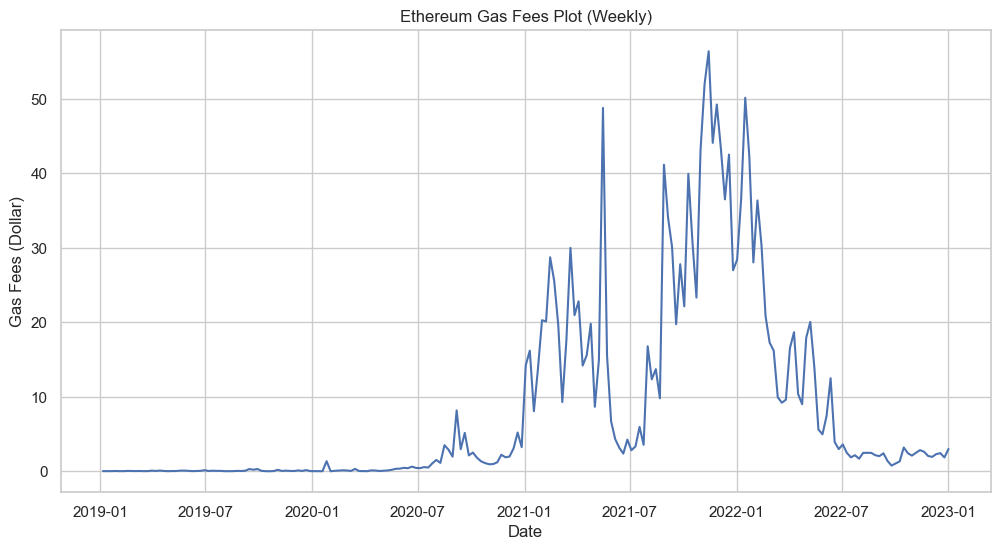

In [19]:
# Plot weekly gas fees
plot_gas_fees(stablecoin['fees'])

In [24]:
def stablecoin_fees_scenarios(df: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe that has different scenarios for Ethereum gas fees each year"""
    scenario_data = []
    for year in range(2019, 2023):
        df_year = df[df.index.year == year]
        # Get the mean value of transaction_fees directly
        mean_fee = df_year['transaction_fees'].describe().loc['mean']
        # Calculate fee percentage for $200
        scenario_data.append({
            'year': year,
            'stablecoin': (mean_fee / 200) * 100
        })
    scenario_df = pd.DataFrame(scenario_data)
    scenario_df = scenario_df.reindex(columns=['year', 'stablecoin'])
    return scenario_df

In [25]:
stablecoin_fees = stablecoin_fees_scenarios(stablecoin['fees'])

stablecoin_fees

,year,stablecoin
0,2019,0.042753
1,2020,0.761924
2,2021,11.167482
3,2022,4.979218


In [ ]:
remittance_path = os.path.join('data/remittance/', 'remittance-tables.xlsx')
# Import remittance dataframes
remittance = gf.import_excel(
    remittance_path,
    ['cost_to_income', 'cost_to_region', 'cost_from_income', 'cost_from_region',
     'inflow_income', 'inflow_region', 'outflow_income', 'outflow_region']
)
# Convert to pandas
for name in remittance:
    # Convert to pandas
    remittance[name] = remittance[name].to_pandas()
    # Impute missing columns in cost_from dataframes
    if name == 'cost_from_income' or name == 'cost_from_region':
        remittance[name] = cc.mf_impute(remittance[name])
    remittance[name].index = remittance[name]['year']
    remittance[name] = remittance[name].drop(columns=['year'])

In [ ]:
import statsmodels.api as sm

def predict_remittance_cost(df: pd.DataFrame) -> pd.DataFrame:
    """Predict remittance costs for the year 2021 and 2022 using linear regression"""
    # Empty predictions dataframe
    pred_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        # Year and remittance cost variables
        X = df.index.values
        y = df[col].values
        # Year constant term
        X = sm.add_constant(X)
        # Fit model with Ordinary Least Squares
        model = sm.OLS(y, X).fit()
        # Predict with fitted model
        pred_X = sm.add_constant([2021, 2022])
        pred_y = model.predict(pred_X)
        # Add the predictions to the dataframe
        pred_df[col] = pred_y
    # Set the index of dataframe
    pred_df.index = [2021, 2022]
    return pred_df

In [ ]:
# Generate predictions for 2021/2022 for income to/from tables
pred_dict = {}
for key in remittance.keys():
    # Check if the dataframe has 2021 and 2022 or not
    if 2021 not in remittance[key].index and 2022 not in remittance[key].index:
        # Call the function on each dataframe
        pred_df = predict_remittance_cost(remittance[key])
        # Store the predictions in the new dict
        pred_dict[key] = pred_df
        # Append the predictions to the original dataframes
        remittance[key] = pd.concat([remittance[key], pred_df], axis=0)

In [ ]:
for name in remittance:
    print(f'\n>>> {name}')
    print(remittance[name])